<a href="https://colab.research.google.com/github/chizkidd/deep-learning-models/blob/main/pytorch/LeNet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning Models: A collection of various deep learning architectures, models, & their implementations (`PyTorch` or `TensorFlow`) in Jupyter Notebooks.
* Author: _Chizoba Obasi_
* Github Repo:

In [1]:
!pip install watermark

In [2]:
%load_ext watermark
# %reload_ext watermark
%watermark -a 'Chizoba Obasi' -v -p tensorflow

Author: Chizoba Obasi

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

tensorflow: 2.15.0



# Implementation of LeNet-5
---

**LeNet-5** is a classic convolutional neural network employing the use of convolutions, pooling and fully connected layers that was developed in 1998 by _Yann Lecun, Leon Bottou, Yoshua Bengio & Patrick Haffner._ It was designed for handwritten digit recognition using the MNIST (Modified National Institute of Standards and Technology) dataset. <u>Animated demonstrations</u> of LeNet-5 can be found [here](https://yann.lecun.com/exdb/lenet/index.html). The original LeNet-5 paper, _**"Gradient Based Learning Applied to Document Recognition,"**_ can be found [here](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) or [here](https://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). According to Yann Lecun, on his LeNet5 [demo](https://yann.lecun.com/exdb/lenet/index.html) page:
>Convolutional Neural Networks are are a special kind of multi-layer neural networks. Like almost every other neural networks they are trained with a version of the back-propagation algorithm. Where they differ is in the architecture.
>  
>Convolutional Neural Networks are designed to recognize visual patterns directly from pixel images with minimal preprocessing. They can recognize patterns with extreme variability (such as handwritten characters), and with robustness to distortions and simple geometric transformations.
>
>LeNet-5 is our latest convolutional network designed for handwritten and machine-printed character recognition.

The MNIST dataset is basically the _"Hello World"_ of computer vision in deep learning. Currently, most deep learning implementations attain $\textbf{~99%}$ accuracy in correct classification of the handwritten digits. The MNIST database can be found [here](https://yann.lecun.com/exdb/mnist/).

The goal is to reproduce the LeNet-5 model in tensorflow as seen in the 1998 paper. To improve accuracy, further modifications that leverage current deep learning advancements will be done to the model.

This notebook implements the classic LeNet-5 convolutional network [1] and applies it to MNIST digit classification. The basic architecture is shown in the figure below:

![LeNet5 model architecture](http://drive.google.com/uc?export=download&id=14om5xslwvpxqhQZqPGqwjMoOYiqpYnM1)



LeNet-5 is commonly regarded as the pioneer of convolutional neural networks, consisting of a very simple architecture (by modern standards). **The LeNet-5 architecture primarily consists of three major layer constructs:**
* Convolutional layers, `C1, C3, C5`
* Sub-sampling layers (pooling), `S2, S4`
* Fully-connected layers (FC), `F6`

In the figure above, convolutional layers are labeled $Cx$, sub-sampling layers are labeled $Sx$, and fully-connected layers are labeled $Fx$, where $x$ is the layer index. In total, LeNet-5 consists of only $7$ layers. $3$ out of these $7$ layers are convolutional layers ($C1, C3, C5$), which are connected by two average pooling layers ($S2, S4$). The penultimate layer is a fully connected layer ($F6$), which is followed by the final output layer. The additional details are summarized below:
```
Model:                   Input --> [  C1  ] -> [  S2  ] -> [  C3  ] -> [  S4  ] -----------> [  C5/F5  ] -> [  F6  ] -> Output
Shape:                   32x32       28x28       14x14       10x10        5x5                    1x1          84          10
Feature Maps:              -           6           6          16          16                     120          -           -
Trainable Params:          -          156                    2,416                              48,120       10,164       850

Implementation:                    ConvNet -> Avg. Pool -> ConvNet -> Avg. Pool -> (Flatten) ---> FC -------> FC -----> Softmax
```

- The input size is $32\times32$; here, we rescale the MNIST images from $28\times28$ to $32\times32$ to match this input dimension.
- All convolutional layers use $5\times5$ kernels with stride $1$.
- The two average pooling (subsampling) layers are $2\times2$ pixels wide with stride $2$.
- The output layer uses $10$ custom `Euclidean Radial Basis Function (RBF)` neurons for the output layer. (**In this notebook, we replace these with `softmax` activations**).



### References

- [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, november 1998.


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.layers import Input, Conv2D, AveragePooling2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import math
import time

In [4]:
print(tf.__version__)

2.15.0


In [5]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Num GPUs Available: ", len(gpus))
    for gpu in gpus:
        print(f"GPU: {gpu}")
else:
    print("No GPU available.")


#------------------------------------------------------------------------------------------------------------------------
# Verify TensorFlow is using GPU
if tf.test.gpu_device_name():
    print('GPU found: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found.")

Num GPUs Available:  1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU found: /device:GPU:0


---
# 0. Model Settings

---

In [6]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 30


# Architecture
INPUT_SHAPE = (32, 32, 1)
NUM_CLASSES = 10

----
# 1. Data Preparation & Loading

----

In [7]:
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()
train_x.shape, type(train_x)


11490434/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), numpy.ndarray)

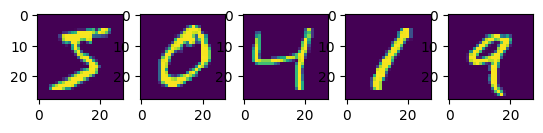

In [8]:
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(train_x[i, :, :])

In [9]:
def preprocess_data(mnist_data, split_ratio=0.08, batch_size=32, preprocess_type='normalize', random_seed=42):
    """
    Preprocess MNIST data with specified method and return TensorFlow datasets.

    Args:
        mnist_data: Tuple containing the MNIST data ((train_images, train_labels), (test_images, test_labels)).
        split_ratio: Float, the ratio of the training data to use for validation.
        batch_size: Integer, the batch size for the datasets.
        preprocess_type: String, 'normalize' or 'standardize' for data preprocessing method.
        random_seed: Integer, the seed for shuffling the data.

    Returns:
        Tuple of TensorFlow datasets: (train_dataset, val_dataset, test_dataset)
    """
    (train_images, train_labels), (test_images, test_labels) = mnist_data

    # Resize images to 32x32 and add channel dimension
    train_images = tf.image.resize(train_images[..., tf.newaxis], [32, 32])
    test_images = tf.image.resize(test_images[..., tf.newaxis], [32, 32])

    if preprocess_type == 'normalize':
        # Normalize pixel values to [0, 1]
        train_images = train_images / 255.0
        test_images = test_images / 255.0

    elif preprocess_type == 'standardize':
        # Standardize pixel values (mean 0, std 1)
        mean_px = tf.reduce_mean(train_images).numpy().astype(float)
        std_px = tf.math.reduce_std(train_images).numpy().astype(float)

        train_images = (train_images - mean_px) / std_px
        test_images = (test_images - mean_px) / std_px

    else:
        raise ValueError("Invalid preprocess_type. Choose 'normalize' or 'standardize'.")

    # Convert labels to one-hot encoding
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)

    # Split the training data into training and validation sets
    num_val_samples = int(split_ratio * len(train_images))
    val_images = train_images[-num_val_samples:]
    val_labels = train_labels[-num_val_samples:]
    train_images = train_images[:-num_val_samples]
    train_labels = train_labels[:-num_val_samples]

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    # Shuffle and batch datasets
    train_dataset = train_dataset.shuffle(buffer_size=len(train_images), seed=random_seed).batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)

    return train_dataset, val_dataset, test_dataset


In [10]:
# Load MNIST data
mnist_data = mnist.load_data()

# Preprocess data with normalization and a fixed random seed
train_dataset, val_dataset, test_dataset = preprocess_data(
    mnist_data, split_ratio=0.08, batch_size=BATCH_SIZE, preprocess_type='normalize', random_seed=RANDOM_SEED)

In [11]:
# Assuming train_dataset is your tf.data.Dataset
for images, labels in train_dataset.take(1):  # Take one batch
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)

Image shape: (64, 32, 32, 1)
Label shape: (64, 10)


---
# 2. Model Creation

----

In [12]:
def LeNet5(input_shape=(32, 32, 1), num_classes=10):

    """
    Builds a LeNet-5 model using the Sequential API.
    Architecture summary: ConvNet -> Avg. Pool -> ConvNet -> Avg. Pool -> (Flatten) --> FC --> FC --> Softmax

    Architecture:
    - Conv2D: Convolutional layer with 6 filters, kernel size 5, activation 'tanh', padding 'valid'
    - AveragePooling2D: Average pooling layer with pool size 2
    - Conv2D: Convolutional layer with 16 filters, kernel size 5, activation 'tanh', padding 'valid'
    - MaxPooling2D: Max pooling layer with pool size 2
    - Flatten: Flatten layer to reshape the output for dense layers
    - Dense: Fully connected layer with 120 units and 'tanh' activation
    - Dense: Fully connected layer with 84 units and 'tanh' activation
    - Dense: Output layer with 'softmax' activation for classification

    Arguments:
    input_shape -- tuple, shape of the input images (height, width, channels). Default is (32, 32, 1).
    num_classes -- integer, number of classes for the output layer. Default is 10.

    Returns:
    model -- a Keras Sequential model instance with the defined architecture.
    """
    model = Sequential([
      # Input layer
      Input(shape=input_shape, name='input_layer'),

      # Layer 1: C1 + S2
      Conv2D(filters=6, kernel_size=5, strides=1, activation='tanh', padding='valid', name='conv_1'),
      AveragePooling2D(pool_size=2, strides=2, name='avg_pool_1'),

      # Layer 2: C3 + S4
      Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', padding='valid', name='conv_2'),
      AveragePooling2D(pool_size=2, strides=2, name='avg_pool2'),

      # Layer 3: Flatten + F5
      Flatten(name='flatten'),
      Dense(units=120, activation='tanh', name='fully_connected_1'),

      # Layer 4: F6
      Dense(units=84, activation='tanh', name='fully_connected_2'),

      # Layer 5: Output
      Dense(units=num_classes, activation='softmax', name='output')

    ])

    model._name = 'LeNet5'

    return model



----
#3. Model Compiling, Training and Testing & Evaluation Plots (Loss, Accuracy)

----
 Functions:
1. `train_model`
2. `plot_history`

In [13]:
def train_model(model, train_dataset, val_dataset, NUM_EPOCHS=20, lr_factor=0.2, lr_patience=2):
    # compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # # Define the custom callback to log train and validation accuracy & learning rate

    class LogMetrics(Callback):
        def __init__(self, model): # Add model as argument
            super(LogMetrics, self).__init__()
            self.model = model # Assign model to self.model
            # self.lrs = []

        def on_train_begin(self, logs=None):
            self.lrs = []

        def on_epoch_end(self, epoch, logs=None):
            val_logs = self.model.evaluate(val_dataset, verbose=0)
            lr = self.model.optimizer.lr.numpy()
            self.lrs.append(lr)
            print(f'Epoch {epoch + 1}/{NUM_EPOCHS} | '
                  f'Train Loss: {logs["loss"]:.5f}, '
                  f'Train Accuracy: {logs["accuracy"]:.5f} | '
                  f'Val Loss: {val_logs[0]:.5f}, '
                  f'Val Accuracy: {val_logs[1]:.5f} | '
                  f'Learning Rate: {lr:.8f}')

    # Define the ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',          # Metric to monitor
        factor=lr_factor,            # Factor by which the learning rate will be reduced
        patience=lr_patience,        # Number of epochs with no improvement after which learning rate will be reduced
    )

    # Create an instance of the LogMetrics callback
    log_metrics = LogMetrics(model)

    # Train the model with both the custom logging and ReduceLROnPlateau callbacks
    start_time = time.time()
    history = model.fit(train_dataset,
                        epochs=NUM_EPOCHS,
                        validation_data=val_dataset,
                        callbacks=[log_metrics, reduce_lr],
                        verbose=0)

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return model, history, log_metrics, reduce_lr


In [14]:
# Plot the training history
def plot_history(history, lrs):
    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, lrs, label='Learning Rate')
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [15]:
# Create the model & Print out model summary
model = LeNet5(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
model.summary()

Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 avg_pool_1 (AveragePooling  (None, 14, 14, 6)         0         
 2D)                                                             
                                                                 
 conv_2 (Conv2D)             (None, 10, 10, 16)        2416      
                                                                 
 avg_pool2 (AveragePooling2  (None, 5, 5, 16)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 fully_connected_1 (Dense)   (None, 120)               48120

Epoch 1/30 | Train Loss: 0.26643, Train Accuracy: 0.92199 | Val Loss: 0.09086, Val Accuracy: 0.97354 | Learning Rate: 0.00100000
Epoch 2/30 | Train Loss: 0.09607, Train Accuracy: 0.97031 | Val Loss: 0.08084, Val Accuracy: 0.97854 | Learning Rate: 0.00100000
Epoch 3/30 | Train Loss: 0.06551, Train Accuracy: 0.97937 | Val Loss: 0.05763, Val Accuracy: 0.98479 | Learning Rate: 0.00100000
Epoch 4/30 | Train Loss: 0.04750, Train Accuracy: 0.98556 | Val Loss: 0.05154, Val Accuracy: 0.98604 | Learning Rate: 0.00100000
Epoch 5/30 | Train Loss: 0.03857, Train Accuracy: 0.98743 | Val Loss: 0.06144, Val Accuracy: 0.98375 | Learning Rate: 0.00100000
Epoch 6/30 | Train Loss: 0.03375, Train Accuracy: 0.98958 | Val Loss: 0.05392, Val Accuracy: 0.98396 | Learning Rate: 0.00100000
Epoch 7/30 | Train Loss: 0.01639, Train Accuracy: 0.99545 | Val Loss: 0.04771, Val Accuracy: 0.98625 | Learning Rate: 0.00020000
Epoch 8/30 | Train Loss: 0.01180, Train Accuracy: 0.99710 | Val Loss: 0.04908, Val Accuracy: 0.98

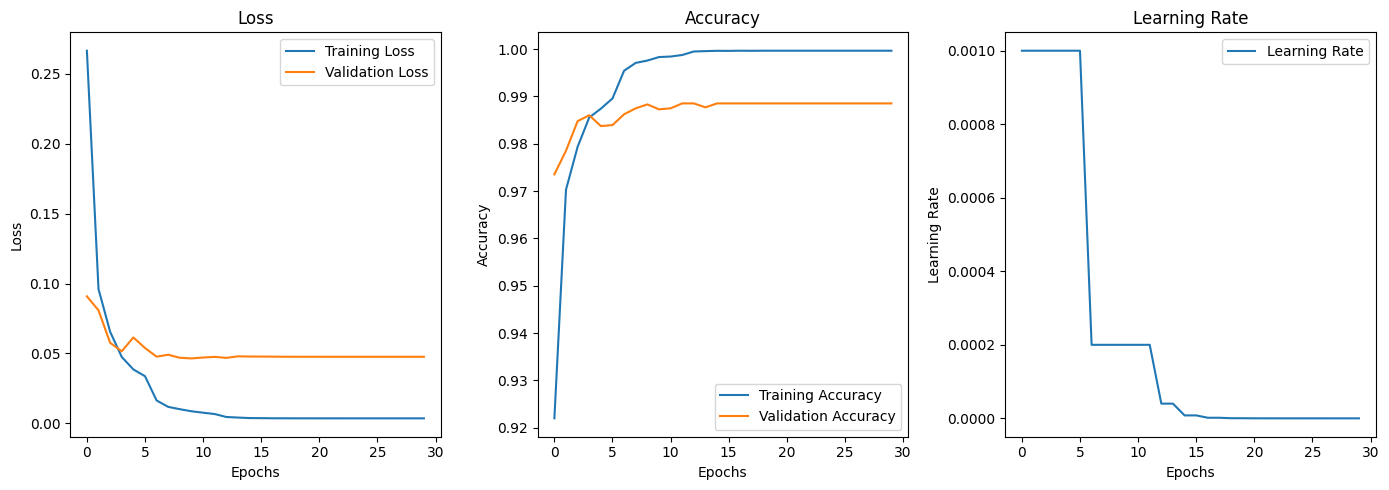

In [16]:
model, history, log_metrics, reduce_lr = train_model(model, train_dataset, val_dataset, NUM_EPOCHS=NUM_EPOCHS)

# Evaluate on test data using model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plot loss and accuracy of training and validation dataset
plot_history(history, log_metrics.lrs)

----
# 4. Modified LeNet-5 Architectures

---
Below are the modified versions of LeNet-5 architecture:
1. **<u>`LeNet5v0`</u>:** ConvNet &rarr; Max. Pool &rarr; ConvNet &rarr; Max. Pool &rarr; (Flatten) &rarr; FC &rarr; FC &rarr; Softmax
- Replace all the instances of **`tanh`** activation functions with **`ReLU`** activation functions in baseline original model from 1998 paper.
- Replace all the instances ($S2, S4$) of **`average pooling`** layers with **`max pooling`** layers.<br><br>

2. **<u>`LeNet5v1`</u>:** ConvNet &rarr; <b>ConvNet</b> &rarr; Max. Pool &rarr; **Dropout** &rarr; ConvNet &rarr; Max. Pool &rarr; **Dropout** &rarr; (Flatten) &rarr; FC &rarr; FC &rarr; Softmax
- Add a **Convolutional layer** directly after $C1$ and before $S2$.
- Add **dropout layers** (`dropout` = $0.25$) directly after both pooling layers.<br><br>

3. **<u>`LeNet5v2`</u>:** ConvNet &rarr; _ConvNet_ &rarr; **BatchNorm** &rarr; Max. Pool &rarr; _Dropout_ &rarr; ConvNet &rarr; **ConvNet** &rarr; **BatchNorm** &rarr; Max. Pool &rarr; _Dropout_ &rarr; (Flatten) &rarr; **FC** &rarr; **BatchNorm** &rarr; FC &rarr; **BatchNorm** &rarr; FC &rarr; **BatchNorm** &rarr; **Dropout** &rarr; Softmax
- Add a **`BatchNorm`** layer directly after $C2$ in `LeNet5v1`.
- Add a **`ConvNet`** & then a **`BatchNorm`** layer directly after new $C3$ in `LeNet5v1`.
- Add a **`FC`** & then a **`BatchNorm`** layer directly after flatten layer.
- Add 2 **`BatchNorm`** layers, one directly before and one after $F8$ in `LeNet5v1`.
- Add a **Dropout** layer right before the output layer.
- Increase number of filter channels (feature maps) for `Convnet` layers consecutively to $32, 32, 64, 64$.
- Set number of hidden units in initial $FC$ layer (directly after flatten layer) and 2nd $FC$ layer (sandwiched with `BatchNorms`) to $256$ and $128$ respectively.
- The use of `BatchNorm` handles `bias` so we can set bias to `False` or $0$ in layers right before `BatchNorm` layer.
- Add **L2 regularization** (`reg_L2` = $0.0005$) in $C1, C3$ layers to reduce overfitting
<br><br>

---

In [17]:
def LeNet5v0(input_shape=(32, 32, 1), num_classes=10, activation='relu'):

    """
    Builds a modified LeNet-5 model using the Sequential API.
    Architecture summary: ConvNet -> Max. Pool -> ConvNet -> Max. Pool -> (Flatten) --> FC --> FC --> Softmax

    Arguments:
    input_shape -- tuple, shape of the input images (height, width, channels). Default is (32, 32, 1).
    num_classes -- integer, number of classes for the output layer. Default is 10.

    Returns:
    model -- a Keras Sequential model instance with the defined architecture.
    """
    model = Sequential([
      # Input layer
      Input(shape=input_shape, name='input_layer'),

      # Layer 1: C1 + S2
      Conv2D(filters=6, kernel_size=5, strides=1, activation=activation, padding='valid', name='conv_1'),
      MaxPooling2D(pool_size=2, strides=2, name='max_pool_1'),

      # Layer 2: C3 + S4
      Conv2D(filters=16, kernel_size=5, strides=1, activation=activation, padding='valid', name='conv_2'),
      MaxPooling2D(pool_size=2, strides=2, name='max_pool_2'),

      # Layer 3: Flatten + F5
      Flatten(name='flatten'),
      Dense(units=120, activation=activation, name='fully_connected_1'),

      # Layer 4: F6
      Dense(units=84, activation=activation, name='fully_connected_2'),

      # Layer 5: Output
      Dense(units=num_classes, activation='softmax', name='output')

    ])

    model._name = 'LeNet5v0'

    return model


#------------------------------------------------------------------------------------------------------------------------
def LeNet5v1(input_shape=(32, 32, 1), num_classes=10, activation='relu'):

    """
    Builds a modified LeNet-5 model using the Sequential API.
    Architecture summary: ConvNet -> [ConvNet] -> Max. Pool -> [Dropout] -> ConvNet -> Max. Pool -> [Dropout] -> (Flatten) -> FC -> FC -> Softmax

    Arguments:
    input_shape -- tuple, shape of the input images (height, width, channels). Default is (32, 32, 1).
    num_classes -- integer, number of classes for the output layer. Default is 10.

    Returns:
    model -- a Keras Sequential model instance with the defined architecture.
    """
    model = Sequential([
      # Input layer
      Input(shape=input_shape, name='input_layer'),

      # Layer 1: C1
      Conv2D(filters=6, kernel_size=5, strides=1, activation=activation, padding='valid', input_shape=input_shape, name='conv_1'),

      # Layer 2: C2 + S2 + D3
      Conv2D(filters=16, kernel_size=5, strides=1, activation=activation, padding='valid', name='conv_2'),
      MaxPooling2D(pool_size=2, strides=2, name='max_pool_1'),
      Dropout(rate=0.25, name='dropout_1'),

      # Layer 3: C4 + S5 + D6
      Conv2D(filters=16, kernel_size=5, strides=1, activation=activation, padding='valid', name='conv_3'),
      MaxPooling2D(pool_size=2, strides=2, name='max_pool_2'),
      Dropout(rate=0.25, name='dropout_2'),

      # Layer 4: Flatten + F7
      Flatten(name='flatten'),
      Dense(units=120, activation=activation, name='fully_connected_1'),

      # Layer 5: F8
      Dense(units=84, activation=activation, name='fully_connected_2'),

      # Layer 6: Output
      Dense(units=num_classes, activation='softmax', name='output')

    ])

    model._name = 'LeNet5v1'

    return model


#------------------------------------------------------------------------------------------------------------------------
def LeNet5v2(input_shape=(32, 32, 1), num_classes=10, l2_reg=0.0005, activation='relu'):

    """
    Builds a modified LeNet-5 model using the Sequential API.
    Architecture summary: ConvNet → ConvNet → [BatchNorm] → Max. Pool → Dropout → ConvNet → [ConvNet] → [BatchNorm] → Max. Pool →
                          Dropout → (Flatten) → [FC] → [BatchNorm] → FC → [BatchNorm] → FC → [BatchNorm] → [Dropout] → Softmax

    Arguments:
    input_shape -- tuple, shape of the input images (height, width, channels). Default is (32, 32, 1).
    num_classes -- integer, number of classes for the output layer. Default is 10.

    Returns:
    model -- a Keras Sequential model instance with the defined architecture.
    """
    model = Sequential([
      # Input layer
      Input(shape=input_shape, name='input_layer'),

      # Layer 1: C1_L2regularized
      Conv2D(filters=32, kernel_size=5, strides=1, activation=activation, padding='valid', input_shape=input_shape, kernel_regularizer=l2(l2_reg), name='conv_1'),

      # Layer 2: C2_no_bias + BN3 + S4 + D5
      Conv2D(filters=32, kernel_size=5, strides=1, activation=activation, padding='valid', use_bias=False, name='conv_2'),
      BatchNormalization(name='batch_norm_1'),
      Activation(activation),
      MaxPooling2D(pool_size=2, strides=2, name='max_pool_1'),
      Dropout(rate=0.25, name='dropout_1'),

      # Layer 3: C6_L2regularized
      Conv2D(filters=64, kernel_size=3, strides=1, activation=activation, padding='valid', kernel_regularizer=l2(l2_reg), name='conv_3'),

      # Layer 4: C7_no_bias + BN8 + S9 + D10
      Conv2D(filters=64, kernel_size=3, strides=1, activation=activation, padding='valid', use_bias=False, name='conv_4'),
      BatchNormalization(name='batch_norm_2'),
      MaxPooling2D(pool_size=2, strides=2, name='max_pool_2'),
      Dropout(rate=0.25, name='dropout_2'),

      # Layer 5: Flatten + F11_no_bias + BN12
      Flatten(name='flatten'),
      Dense(units=256, activation=activation, use_bias=False, name='fully_connected_1'),
      BatchNormalization(name='batch_norm_3'),
      Activation(activation),

      # Layer 6: F13_no_bias + BN14
      Dense(units=128, activation=activation, use_bias=False, name='fully_connected_2'),
      BatchNormalization(name='batch_norm_4'),
      Activation(activation),

      # Layer 7: F15_no_bias + BN16 + D17
      Dense(units=84, activation=activation, use_bias=False, name='fully_connected_3'),
      BatchNormalization(name='batch_norm_5'),
      Activation(activation),
      Dropout(rate=0.25, name='dropout_3'),

      # Layer 8: Output
      Dense(units=num_classes, activation='softmax', name='output')

    ])

    model._name = 'LeNet5v2'

    return model


----
# 5. `LeNet5v0`

----
**<u>`LeNet5v0`</u>:** ConvNet &rarr; Max. Pool &rarr; ConvNet &rarr; Max. Pool &rarr; (Flatten) &rarr; FC &rarr; FC &rarr; Softmax


In [18]:
factor = 0.5
patience = 4

In [19]:
# Create the model & Print out model summary
LeNet5v0_model = LeNet5v0(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
LeNet5v0_model.summary()

Model: "LeNet5v0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 6)         0         
                                                                 
 conv_2 (Conv2D)             (None, 10, 10, 16)        2416      
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 5, 5, 16)          0         
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 fully_connected_1 (Dense)   (None, 120)               48120     
                                                                 
 fully_connected_2 (Dense)   (None, 84)                101

Epoch 1/20 | Train Loss: 0.23470, Train Accuracy: 0.92951 | Val Loss: 0.07250, Val Accuracy: 0.97958 | Learning Rate: 0.00100000
Epoch 2/20 | Train Loss: 0.07117, Train Accuracy: 0.97813 | Val Loss: 0.05793, Val Accuracy: 0.98188 | Learning Rate: 0.00100000
Epoch 3/20 | Train Loss: 0.05167, Train Accuracy: 0.98379 | Val Loss: 0.05647, Val Accuracy: 0.98250 | Learning Rate: 0.00100000
Epoch 4/20 | Train Loss: 0.03968, Train Accuracy: 0.98737 | Val Loss: 0.04598, Val Accuracy: 0.98687 | Learning Rate: 0.00100000
Epoch 5/20 | Train Loss: 0.03226, Train Accuracy: 0.98947 | Val Loss: 0.05658, Val Accuracy: 0.98583 | Learning Rate: 0.00100000
Epoch 6/20 | Train Loss: 0.02819, Train Accuracy: 0.99054 | Val Loss: 0.03960, Val Accuracy: 0.98833 | Learning Rate: 0.00100000
Epoch 7/20 | Train Loss: 0.02230, Train Accuracy: 0.99254 | Val Loss: 0.04549, Val Accuracy: 0.98646 | Learning Rate: 0.00100000
Epoch 8/20 | Train Loss: 0.01912, Train Accuracy: 0.99399 | Val Loss: 0.03559, Val Accuracy: 0.99

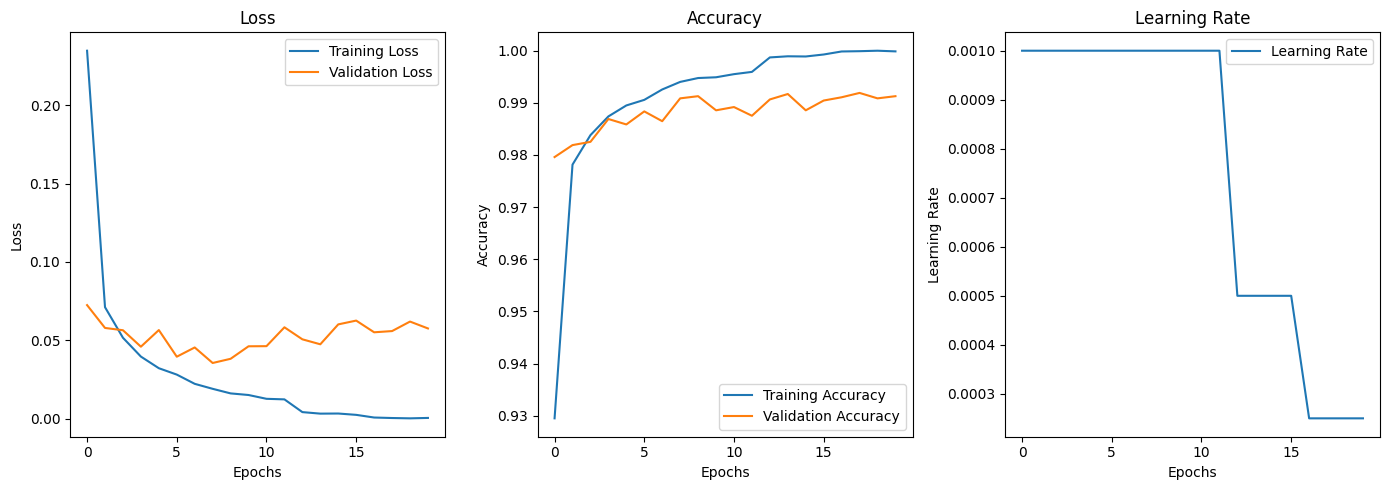

In [20]:
LeNet5v0_model, history_v0, log_metrics_v0, reduce_lr_v0 = train_model(LeNet5v0_model, train_dataset, val_dataset, lr_factor=factor, lr_patience=patience)

# Evaluate on test data using model
test_loss_v0, test_accuracy_v0 = LeNet5v0_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss_v0:.4f}, Test Accuracy: {test_accuracy_v0:.4f}')

# Plot loss and accuracy of training and validation dataset
plot_history(history_v0, log_metrics_v0.lrs)


----
# 6. `LeNet5v1`

----
**<u>`LeNet5v1`</u>:** ConvNet &rarr; <b>ConvNet</b> &rarr; Max. Pool &rarr; **Dropout** &rarr; ConvNet &rarr; Max. Pool &rarr; **Dropout** &rarr; (Flatten) &rarr; FC &rarr; FC &rarr; Softmax


In [21]:
# Create the model & Print out model summary
LeNet5v1_model = LeNet5v1(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
LeNet5v1_model.summary()

Model: "LeNet5v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 conv_2 (Conv2D)             (None, 24, 24, 16)        2416      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 12, 12, 16)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 16)        0         
                                                                 
 conv_3 (Conv2D)             (None, 8, 8, 16)          6416      
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 4, 4, 16)          0         
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 16)          0  

Epoch 1/20 | Train Loss: 0.29891, Train Accuracy: 0.90254 | Val Loss: 0.07618, Val Accuracy: 0.97833 | Learning Rate: 0.00100000
Epoch 2/20 | Train Loss: 0.09538, Train Accuracy: 0.97067 | Val Loss: 0.04501, Val Accuracy: 0.98792 | Learning Rate: 0.00100000
Epoch 3/20 | Train Loss: 0.07163, Train Accuracy: 0.97699 | Val Loss: 0.04465, Val Accuracy: 0.98625 | Learning Rate: 0.00100000
Epoch 4/20 | Train Loss: 0.05960, Train Accuracy: 0.98121 | Val Loss: 0.03705, Val Accuracy: 0.98875 | Learning Rate: 0.00100000
Epoch 5/20 | Train Loss: 0.05157, Train Accuracy: 0.98409 | Val Loss: 0.04083, Val Accuracy: 0.98958 | Learning Rate: 0.00100000
Epoch 6/20 | Train Loss: 0.04948, Train Accuracy: 0.98491 | Val Loss: 0.03803, Val Accuracy: 0.98979 | Learning Rate: 0.00100000
Epoch 7/20 | Train Loss: 0.04374, Train Accuracy: 0.98649 | Val Loss: 0.03241, Val Accuracy: 0.99104 | Learning Rate: 0.00100000
Epoch 8/20 | Train Loss: 0.04110, Train Accuracy: 0.98688 | Val Loss: 0.03084, Val Accuracy: 0.99

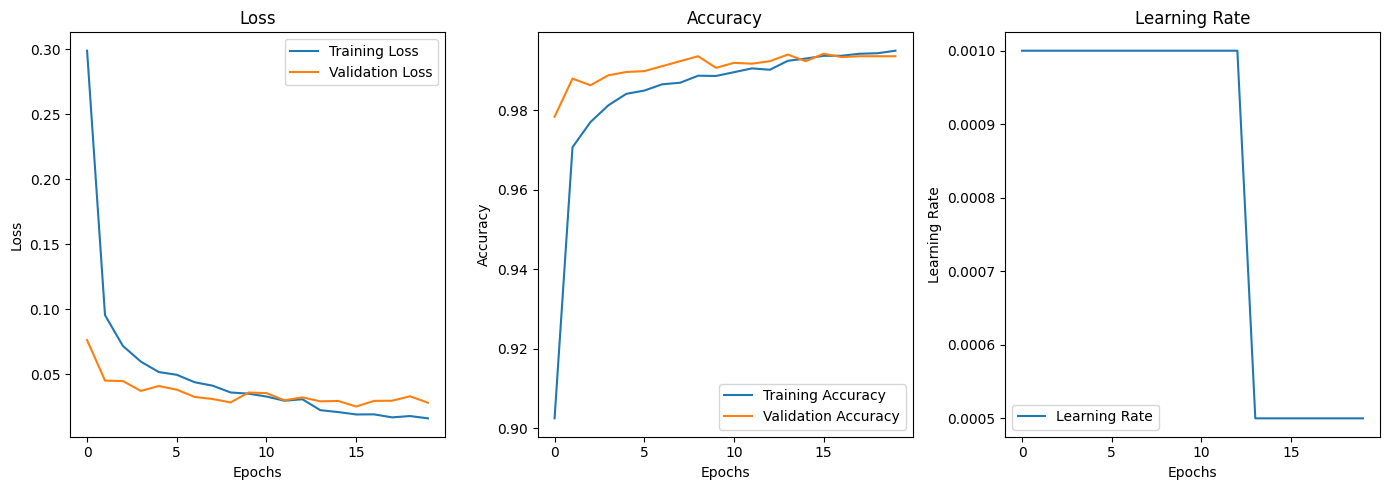

In [22]:
LeNet5v1_model, history_v1, log_metrics_v1, reduce_lr_v1 = train_model(LeNet5v1_model, train_dataset, val_dataset, lr_factor=factor, lr_patience=patience)

# Evaluate on test data using model
test_loss_v1, test_accuracy_v1 = LeNet5v1_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss_v1:.4f}, Test Accuracy: {test_accuracy_v1:.4f}')

# Plot loss and accuracy of training and validation dataset
plot_history(history_v1, log_metrics_v1.lrs)


----
# 7. `LeNet5v2`

----
**<u>`LeNet5v2`</u>:** ConvNet &rarr; _ConvNet_ &rarr; **BatchNorm** &rarr; Max. Pool &rarr; _Dropout_ &rarr; ConvNet &rarr; **ConvNet** &rarr; **BatchNorm** &rarr; Max. Pool &rarr; _Dropout_ &rarr; (Flatten) &rarr; **FC** &rarr; **BatchNorm** &rarr; FC &rarr; **BatchNorm** &rarr; FC &rarr; **BatchNorm** &rarr; **Dropout** &rarr; Softmax

In [23]:
# Create the model & Print out model summary
LeNet5v2_model = LeNet5v2(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
LeNet5v2_model.summary()

Model: "LeNet5v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv_2 (Conv2D)             (None, 24, 24, 32)        25600     
                                                                 
 batch_norm_1 (BatchNormali  (None, 24, 24, 32)        128       
 zation)                                                         
                                                                 
 activation (Activation)     (None, 24, 24, 32)        0         
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 12, 12, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0         
                                                          

Epoch 1/20 | Train Loss: 0.33171, Train Accuracy: 0.91556 | Val Loss: 0.07906, Val Accuracy: 0.98333 | Learning Rate: 0.00100000
Epoch 2/20 | Train Loss: 0.10884, Train Accuracy: 0.97612 | Val Loss: 0.06044, Val Accuracy: 0.98937 | Learning Rate: 0.00100000
Epoch 3/20 | Train Loss: 0.08394, Train Accuracy: 0.98123 | Val Loss: 0.05828, Val Accuracy: 0.98854 | Learning Rate: 0.00100000
Epoch 4/20 | Train Loss: 0.07169, Train Accuracy: 0.98404 | Val Loss: 0.04870, Val Accuracy: 0.98937 | Learning Rate: 0.00100000
Epoch 5/20 | Train Loss: 0.06028, Train Accuracy: 0.98676 | Val Loss: 0.06390, Val Accuracy: 0.98771 | Learning Rate: 0.00100000
Epoch 6/20 | Train Loss: 0.05621, Train Accuracy: 0.98726 | Val Loss: 0.05090, Val Accuracy: 0.99021 | Learning Rate: 0.00100000
Epoch 7/20 | Train Loss: 0.03982, Train Accuracy: 0.99170 | Val Loss: 0.03593, Val Accuracy: 0.99146 | Learning Rate: 0.00050000
Epoch 8/20 | Train Loss: 0.03467, Train Accuracy: 0.99248 | Val Loss: 0.03546, Val Accuracy: 0.99

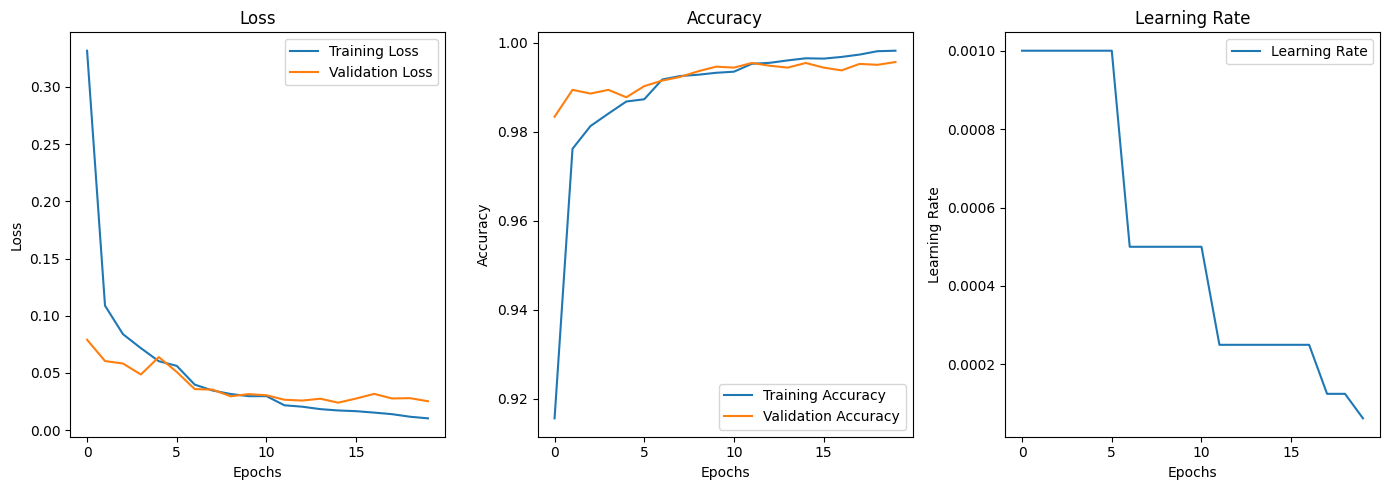

In [24]:
LeNet5v2_model, history_v2, log_metrics_v2, reduce_lr_v2 = train_model(LeNet5v2_model, train_dataset, val_dataset, lr_factor=factor, lr_patience=2)

# Evaluate on test data using model
test_loss_v2, test_accuracy_v2 = LeNet5v0_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss_v2:.4f}, Test Accuracy: {test_accuracy_v2:.4f}')

# Plot loss and accuracy of training and validation dataset
plot_history(history_v2, log_metrics_v2.lrs)

----
# A. Model Performance for Various Modified Versions of `LeNet-5`

---

| S/o. | Model Changes | Epochs | Train loss | Train Acc. | Val loss | Val. Acc.(%) | Test Loss | Test Acc.(%) | Error rate (%) |
| - | - | - | - | - | - | - | - | - | - |
| 1. | **Baseline** | 10 | 0.0083 | 99.83 | 0.0437 | 98.98 | 0.0365 | 98.89 | 1.11
| 2. | **Baseline** | 30 | 0.00361 | 99.97 | 0.0476 | 98.85 | 0.0370 | 98.79 | 1.21
| 3. | **LeNet5_v0** | 20 | 0.00056 | 99.98 | 0.0576 | 99.12 | 0.0340 | 99.19 | 0.81
| 4. | **LeNet5_v1** | 20 | 0.01596 | 99.49 | 0.0280 | 99.35 | 0.0217 | 99.26 | 0.74
| 5. | **LeNet5_v2** | 20 | 0.01035 | 99.82 | 0.0252 | 99.56 | 0.0340 | 99.19 | 0.81

In [26]:
%watermark -iv

numpy     : 1.26.4
keras     : 2.15.0
pandas    : 2.1.4
matplotlib: 3.7.1
tensorflow: 2.15.0

